## Projekt

### Importy knihoven

In [1]:
import numpy as np
import cv2
import pywt
import time
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

### Funkce pro svd kompresi

In [2]:
def get_svd_compression(image, target_ratio):
    """
    Vypočítá k tak, aby odpovídalo kompresnímu poměru a provede SVD.
    """
    m, n = image.shape
    k = int((m * n) / (target_ratio * (m + n + 1)))                 # m*k + k*n + k
    k = max(1, min(k, min(m, n)))                                   # pocet singularinch hodnot bude nejvyse mensi z rozmeru matice a nejmene 1 (ochrana proti nevzhovujicim pomerum komprese)
    
    start = time.time()
    U, sig, Vt = np.linalg.svd(image, full_matrices=False)          
    sig_k = np.zeros_like(sig)
    sig_k[:k] = sig[:k]                                             # pouze k nejvetsich hodnot
    reconstructed = np.dot(U, np.dot(np.diag(sig_k), Vt))
    end = time.time()
    
    return np.clip(reconstructed, 0, 1), end - start, k             # clipneme hodnotz v rekonstruovane matici na interval [0, 1]

### Funkce pro wavelet kompresi

In [3]:
def get_wavelet_compression(image, target_ratio, wavelet='db4', level=4):
    """
    Ponechá (1/target_ratio) % největších koeficientů waveletové transformace.
    """
    m, n = image.shape
    total_pixels = m * n
    coefs_used = int(total_pixels / target_ratio)           # pocet koeficientu, ktere vyuzijeme

    start = time.time()
    coefs = pywt.wavedec2(image, wavelet, level=level)      # coefs je seznam matic koeficientu
    coefs_array, coef_slices = pywt.coeffs_to_array(coefs)  # coefs_slices je maoa pro zpetnou rekonstrukci
    abs_coeffs = np.abs(coefs_array)
    divider = np.sort(abs_coeffs.ravel())[-coefs_used]      # najdeme prahovou hodnotu mezi koeficientz co pouzije a temi ktere ne
    coefs_array[np.abs(coefs_array) < divider] = 0          # koeficienty pod carou prepiseme na 0
    
    new_coeffs = pywt.array_to_coeffs(coefs_array, coef_slices, output_format='wavedec2')       # zisk seznamu matic novych koeficientu pro rekonstrukci
    reconstructed = pywt.waverec2(new_coeffs, wavelet)                                          # rekonstrukce
    end = time.time()
    
    return np.clip(reconstructed[:m, :n], 0, 1), end - start, coefs_used

### Funkce pro analýzu parametrů u jednotlivých metod

In [4]:
def run_parameter_analysis(image, image_name):
    """
    Analýza vlivu parametrů: k u SVD a level u Waveletů.
    """
    print(f"\n--- Analýza parametrů pro: {image_name} ---")

    levels = [1, 2, 3, 4, 5, 6]                                                     # urovne rozkladu waveletu
    wav_psnr = []
    for lvl in levels:
        reconstructed, _, _ = get_wavelet_compression(image, target_ratio=25, level=lvl)    # podtrzitka, protoze chceme jenom rekonstruovany orbazek, zvolime pro test ration napr 25
        wav_psnr.append(psnr(image, reconstructed, data_range=1.0))                         # fce psnr proovna rozdily v signalu mezi originalem a rekonstrukci
        print(f"  Wavelet Level {lvl} hotov.")

    ratios = [5, 10, 20, 50, 100, 200]              # pro predstavu pouzijeme pomery, z nichz singularni hodnoty k vyplyvaji
    svd_psnr = []
    k_values = []
    for r in ratios:
        reconstructed, _, k = get_svd_compression(image, r)
        svd_psnr.append(psnr(image, reconstructed, data_range=1.0))
        k_values.append(k)
        print(f"  SVD Ratio {r}:1 (k={k}) hotov.")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(levels, wav_psnr, marker='o', color='blue', linewidth=2)
    ax1.set_title(f"Vliv úrovně rozkladu (Wavelet)")
    ax1.set_xlabel("Úroveň rozkladu (level)")
    ax1.set_ylabel("PSNR [dB]")
    ax1.grid(True)

    ax2.plot(k_values, svd_psnr, marker='s', color='red', linewidth=2)
    ax2.set_title(f"Vliv počtu singulárních hodnot (SVD)")
    ax2.set_xlabel("Počet singulárních hodnot (k)")
    ax2.set_ylabel("PSNR [dB]")
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f"graphs_{image_name.split('.')[0]}.png")
    print(f" Vizualizace analýzy vlivu parametrů uložena jako graphs_{image_name.split('.')[0]}.png")
    plt.show()

### Main a výsledky porovnání kompresí


Zpracovávám obrázek: 1.jpg
Metoda     | Poměr  | PSNR [dB] | SSIM     | Čas [s]    | Parametr
-----------------------------------------------------------------
SVD        |    50:1 |   29.22 |   0.770 |   28.3285 | k=34
Wavelet    |    50:1 |   35.69 |   0.855 |    1.4557 | level=3

--- Analýza parametrů pro: 1.jpg ---
  Wavelet Level 1 hotov.
  Wavelet Level 2 hotov.
  Wavelet Level 3 hotov.
  Wavelet Level 4 hotov.
  Wavelet Level 5 hotov.
  Wavelet Level 6 hotov.
  SVD Ratio 5:1 (k=342) hotov.
  SVD Ratio 10:1 (k=171) hotov.
  SVD Ratio 20:1 (k=85) hotov.
  SVD Ratio 50:1 (k=34) hotov.
  SVD Ratio 100:1 (k=17) hotov.
  SVD Ratio 200:1 (k=8) hotov.
 Vizualizace analýzy vlivu parametrů uložena jako graphs_1.png


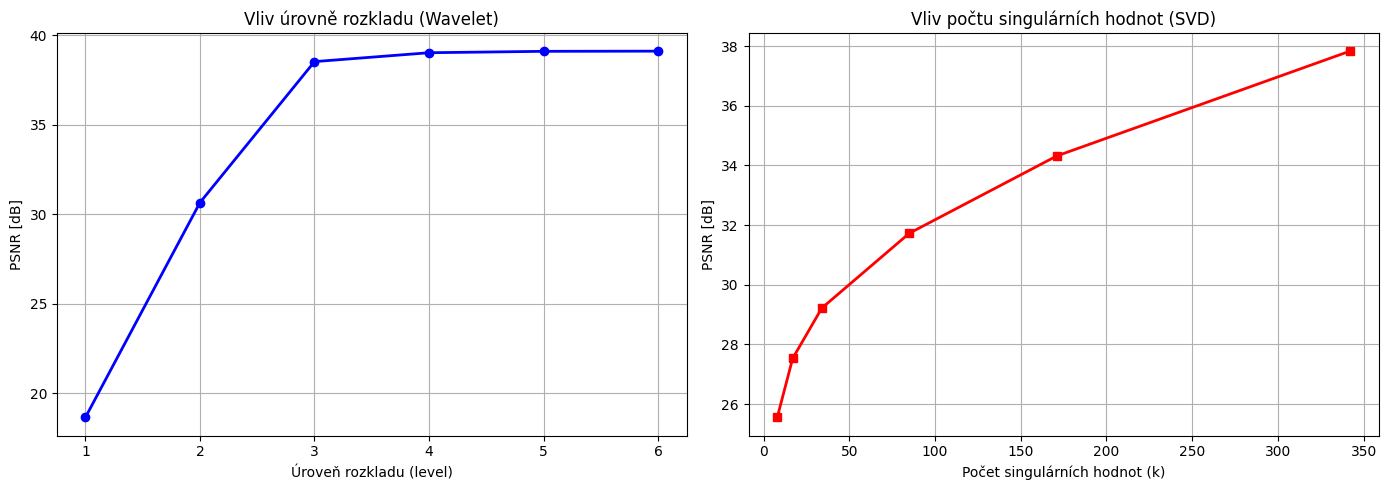

In [5]:
def main():
    FILES_TO_TEST = ['1.jpg']
    RATIOS = [50]

    for path in FILES_TO_TEST:
        print(f"\n{'='*60}")
        print(f"Zpracovávám obrázek: {path}")
        print(f"{'='*60}")
        
        img_orig = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img_orig is None:
            print(f"CHYBA: Soubor {path} nebyl nalezen")
            continue
        
        img = img_orig.astype(float) / 255.0

        print(f"{'Metoda':<10} | {'Poměr':<6} | {'PSNR [dB]':<8} | {'SSIM':<8} | {'Čas [s]':<10} | {'Parametr'}")
        print("-" * 65)

        for r in RATIOS:
            img_svd, time_svd, k_svd = get_svd_compression(img, r)
            psnr_svd = psnr(img, img_svd, data_range=1.0)
            ssim_svd = ssim(img, img_svd, data_range=1.0)
            print(f"{'SVD':<10} | {r:>5}:1 | {psnr_svd:>7.2f} | {ssim_svd:>7.3f} | {time_svd:>9.4f} | k={k_svd}")

            img_wav, time_wav, _ = get_wavelet_compression(img, r, wavelet='db4', level=3)                          # pro waveleta bzla konkr0tne vybrana vlnka db4, proto6e se hodi na tento typ obrayzku
            psnr_wav = psnr(img, img_wav, data_range=1.0)
            ssim_wav = ssim(img, img_wav, data_range=1.0)
            print(f"{'Wavelet':<10} | {r:>5}:1 | {psnr_wav:>7.2f} | {ssim_wav:>7.3f} | {time_wav:>9.4f} | level=3")
            
            cv2.imwrite(f"svd_{r}_{path}", (img_svd * 255).astype(np.uint8))
            cv2.imwrite(f"wav_{r}_{path}", (img_wav * 255).astype(np.uint8))

        run_parameter_analysis(img, path)     # analyza parametru

if __name__ == "__main__":
    main()